In [1]:
import pandas as pd
import os
from typing import List
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
go_file = "/Users/kajolpatel/Desktop/Individual_Project/poc/go-basic.obo"

### Parse the Dataset

In [3]:
def parse_obo_file(file_path):
    
    data = []
    current_term = {}
    in_term_block = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '[Term]':  #starting a new term block
                if current_term:
                    data.append(current_term)
                current_term = {}
                in_term_block = True
            elif line == '':
                in_term_block = False  #end of a term block
            elif in_term_block:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    if key in current_term:  #handling multiple lines of the same key
                        if isinstance(current_term[key], list):
                            current_term[key].append(value)
                        else:
                            current_term[key] = [current_term[key], value]
                    else:
                        current_term[key] = value

    
    if current_term: #add the last term if file does not end with a newline
        data.append(current_term)

    return pd.DataFrame(data)

df = parse_obo_file(go_file)


In [4]:
#ypdating 'def' column to 'definition'
df = df.rename(columns={'def': 'definition'}) 

In [5]:
df.head(4)

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN


In [6]:
df['id'].nunique()

47856

In [7]:
df.namespace.nunique()

3

In [8]:
df.namespace.value_counts()


namespace
biological_process    30723
molecular_function    12614
cellular_component     4519
Name: count, dtype: int64

In [9]:
df[df.is_obsolete == 'true']

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN
6,GO:0000008,obsolete thioredoxin,molecular_function,"""OBSOLETE. A small disulfide-containing redox ...","""thioredoxin"" EXACT []",NaN,GO:0000013,This term was made obsolete because it represe...,true,NaN,"[GO:0003756, GO:0015036]",NaN,NaN,NaN
17,GO:0000020,obsolete negative regulation of recombination ...,biological_process,"""OBSOLETE. Any process that stops, prevents, o...","""negative regulation of recombination within r...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,GO:0045950,NaN,NaN,NaN
33,GO:0000039,obsolete plasma membrane long-chain fatty acid...,molecular_function,"""OBSOLETE. (Was not defined before being made ...","""plasma membrane long-chain fatty acid transpo...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,"[GO:0005324, GO:0005886]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47792,GO:2001254,obsolete negative regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that stops, prevents or...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0006338,NaN,NaN,NaN
47793,GO:2001255,obsolete positive regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that activates or incre...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0140673,NaN,NaN,NaN
47811,GO:2001273,obsolete regulation of glucose import in respo...,biological_process,"""OBSOLETE. Any process that modulates the freq...","""regulation of cellular glucose import in resp...",NaN,NaN,This term was obsoleted because it represents ...,true,NaN,NaN,NaN,NaN,NaN
47812,GO:2001274,obsolete negative regulation of glucose import...,biological_process,"""OBSOLETE. Any process that stops, prevents or...","""negative regulation of cellular glucose impor...",NaN,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN


In [10]:
df[df.is_obsolete.isna() == True]

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...","""1,6-alpha-mannosyltransferase activity"" EXACT []",GO:0000030 ! mannosyltransferase activity,NaN,NaN,NaN,NaN,NaN,"Reactome:R-HSA-449718 ""Addition of a third man...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47851,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways involving...","""UDP-4-deoxy-4-formamido-beta-L-arabinopyranos...","[GO:0006040 ! amino sugar metabolic process, G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47852,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009227 ! nucleotide-sugar catabolic proce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47853,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009226 ! nucleotide-sugar biosynthetic pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47854,GO:2001316,kojic acid metabolic process,biological_process,"""The chemical reactions and pathways involving...","[""5-hydroxy-2-(hydroxymethyl)-4H-pyran-4-one m...",[GO:0034308 ! primary alcohol metabolic proces...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

### 1. Remove obsolete terms

In [11]:
df.is_obsolete.value_counts()

is_obsolete
true    5653
Name: count, dtype: int64

In [12]:
df = df[df.is_obsolete.isna() == True]

In [13]:
df.namespace.value_counts()

namespace
biological_process    27014
molecular_function    11132
cellular_component     4057
Name: count, dtype: int64

### 2. Remove unnecessary columns

In [14]:
df = df[['id','namespace','definition']]

### 3. Convert the defintions into feature vectors 
The stop words will be removed in process.

Note that when transforming the definitions to feature vectors, there are 38093 columns created which may create issues like overfitting, curse of dimensionality, etc. 

To handle this we will exclude some words that do not appear in some % of definitions. 

We will test for words that do not appear in 1% of definitions and 5% of definitions.
For this experiment, we create 2 separate datasets.

(Where one dataset excludes the words that do not appear in 1% of the defintions and the other dataset that excludes words that do not appear in 5 % of the definitions)

a. Dataset that excludes words that do not appear in 1% of definitions

This gives 202 columns

In [21]:
vectorizer1 = CountVectorizer(stop_words='english', min_df=0.01)
X1 = vectorizer1.fit_transform(df['definition'])
dense_X1 = X1.toarray()
#creating a df with feature names as columns
X1_df = pd.DataFrame(dense_X1, columns=vectorizer1.get_feature_names_out())

b. Dataset that excludes words that do not appear in 5% of definitions

This gives 37 columns.

In [25]:
vectorizer5 = CountVectorizer(stop_words='english', min_df=0.05)
X5 = vectorizer5.fit_transform(df['definition'])
dense_X5 = X5.toarray()
#creating a df with feature names as columns
X5_df = pd.DataFrame(dense_X5, columns=vectorizer5.get_feature_names_out())

In [28]:
X5_df

,acid,activates,activity,ai,binding,catalysis,cell,cells,chemical,complex,...,process,protein,rate,reaction,reactions,reduces,resulting,rhea,stops,termgenie
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42198,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
42199,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
42200,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
42201,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## KNN

### Ignoring the words that do not appear in 5% of the defintions

- The stop words have been removed while transforming the definitions to feature vectors

In [15]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
#creating a df with feature names as columns
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())

In [16]:
X_df.head(3)

,000,0000005,0000010,0000014,0000015,0000021,0000022,0000026,0000031,0000033,...,zygospore,zygospores,zygote,zygotene,zygotes,zygotic,zymogen,zymogens,zymosterol,zzz3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [39]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.953560004738775 at K = 1


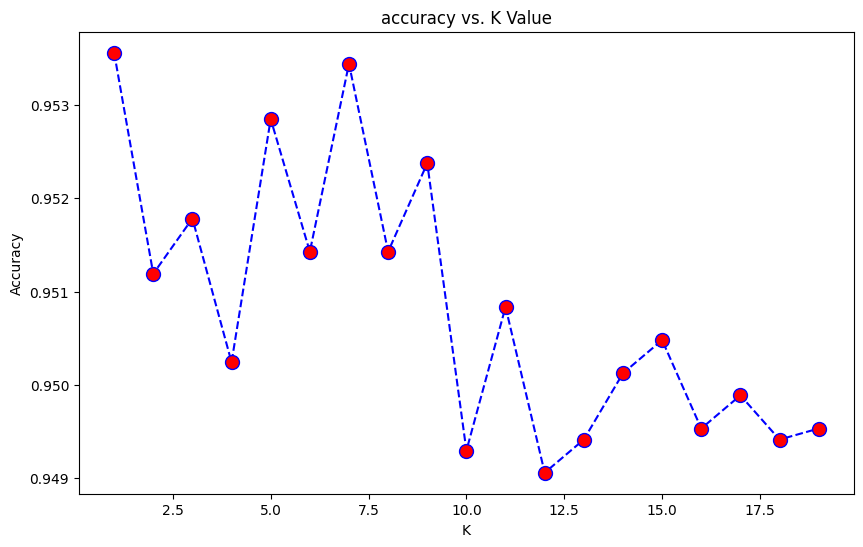

In [35]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

In [18]:
neigh = KNeighborsClassifier(n_neighbors = 18).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [133]:
confusion_matrix(y_test,y_pred)

array([[5229,  104,   39],
       [ 258,  540,   22],
       [ 104,   72, 2073]])

In [134]:
accuracy_score(y_test, y_pred)

0.9290368439758322

### KNN using CountVectorizer on Normalized data

In [135]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.05)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)

In [138]:
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())

In [136]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [114]:
confusion_matrix(y_test,y_pred)

array([[5208,   90,   74],
       [ 262,  510,   48],
       [  83,   48, 2118]])

In [115]:
accuracy_score(y_test,y_pred)

0.9283260277218339

In [144]:
acc = []
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9283260277218339 at K = 11


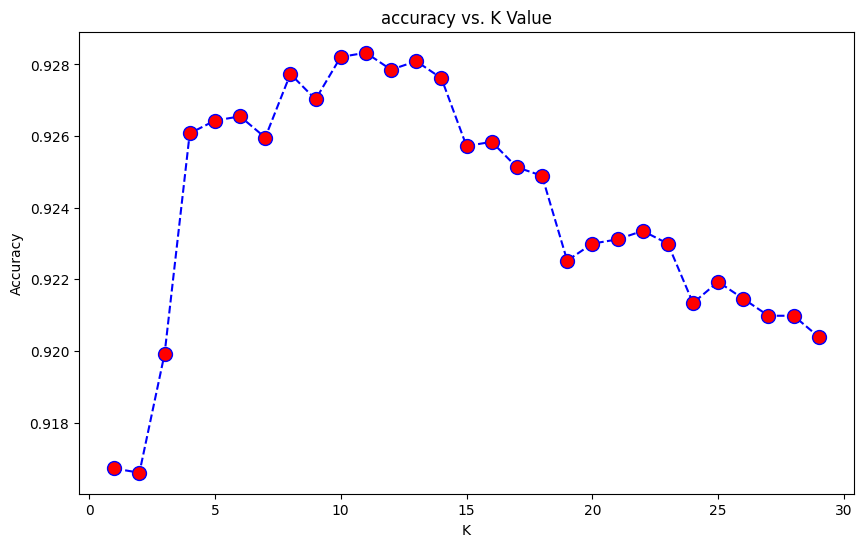

In [145]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)) +1)

In [149]:
accuracy_score(y_test,y_pred)

0.9283260277218339

#### Exp with ignoring words that appear in less than 1 % definitions

In [118]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [120]:
acc = []
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.953560004738775 at K = 1


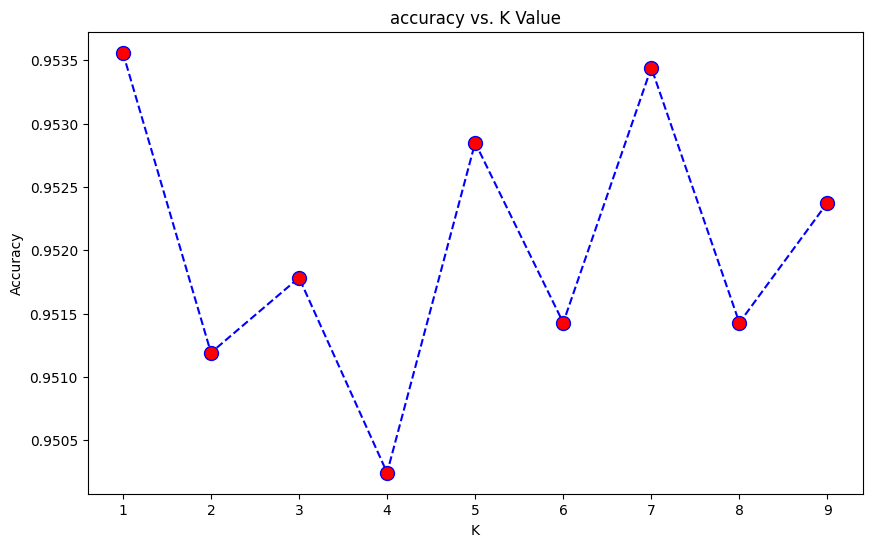

In [121]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

In [122]:
max(acc)

0.953560004738775

### ignoring words that appear in less than 1 % definitions (normalized data)

In [150]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [153]:
acc = []
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.942305414050468 at K = 1


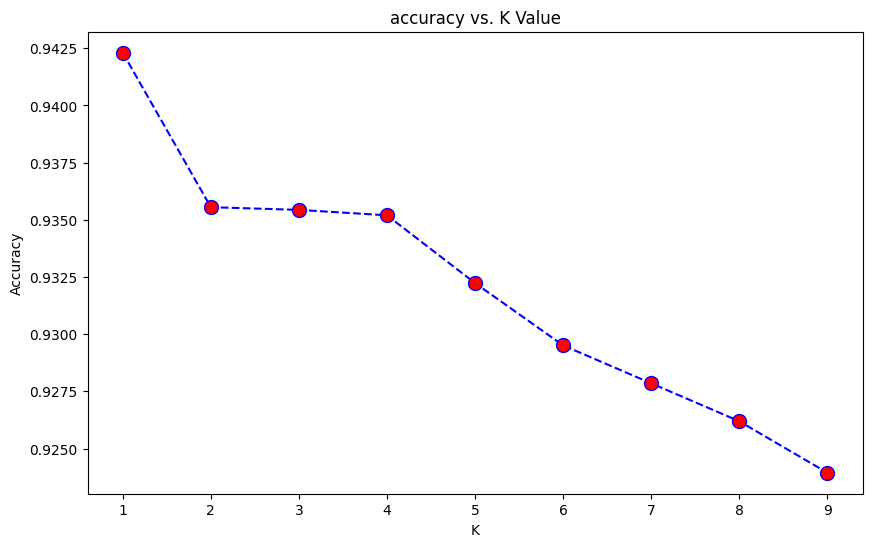

In [154]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

- max accuracy with KNN using Count Vectorizer : 0.9290368439758322 (K = 18)
- max accuracy with KNN using CountVectorizer on Normalized data: 0.9283260277218339 (K = 11)
- max accuracy with KNN using CountVectorizer on ignoring words that do not appear in 1% of definitions: 0.953560004738775 (K = 1)
- max accuracy with KNN using CountVectorizer on Normalized data ignoring words that do not appear in 1% of definitions: 0.942305414050468 (K = 1)

### Support Vector Machines

#### Ignoring the words that do not appear in 1% of definitions

In [27]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [24]:
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


In [25]:
accuracy_score(y_test, y_pred)

0.9463333728231252

In [33]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

In [31]:
grid_search.best_estimator_

SVC(C=10, class_weight='balanced', random_state=42)

In [32]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [28]:
clf_svm = SVC(random_state=42, C=10)
clf_svm.fit(X_train, y_train)

SVC(C=10, random_state=42)

In [31]:
y_pred = clf_svm.predict(X_test)


In [32]:
confusion_matrix(y_test, y_pred)

array([[5299,   60,   13],
       [  95,  710,   15],
       [  26,   20, 2203]])

In [33]:
accuracy_score(y_test, y_pred)

0.9728705129723967

##### Accuracy score using SVM and ignoring words that do not appear in 1% of  definitions: 0.9728705129723967

#### Ignoring the words that do not appear in 5% of definitions

In [34]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.05)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [35]:
clf_svm = SVC(random_state=42, C=10)
clf_svm.fit(X_train, y_train)

SVC(C=10, random_state=42)

In [36]:
y_pred = clf_svm.predict(X_test)


In [37]:
confusion_matrix(y_test, y_pred)

array([[5263,   74,   35],
       [ 265,  532,   23],
       [  75,   61, 2113]])

In [38]:
accuracy_score(y_test, y_pred)

0.936855822769814

### Random Forests

In [42]:
#ignoring words not appearing in 5% defs
vectorizer = CountVectorizer(stop_words='english', min_df=0.05)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
y = df['namespace']
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [46]:
rf = RandomForestClassifier()

In [47]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.9360265371401493

In [49]:
#ignoring words not appearing in 1% defs
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
y = df['namespace']
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [50]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9748844923587253

### Optimize Random Forests

### Method

1. Breakdown input text into feature set
2. Run KNN on definitions using feature set

##### Function to get feature set from an input text




In [76]:
"""
    Takes a paragraph 
"""
def get_feature_set_from_text(input_text: str)->List[str]:
    return []
